# Loading CLIP from Source

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-npgv90kp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-npgv90kp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch
from pkg_resources import packaging
import clip
from PIL import Image
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


from collections import OrderedDict
import torch


print("Torch version:", torch.__version__)
print(clip.available_models())

Torch version: 2.4.1+cu121
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [3]:
# Some CLIP params
model, preprocess = clip.load("ViT-B/32")
#model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x15545c29b6a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Testing CLIP Tokenizer

In [5]:
clip.tokenize("Hey, my name is Irish")

tensor([[49406,  2189,   267,   607,  1981,   533,  4889, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Loading 8 sample images and their descriptions

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

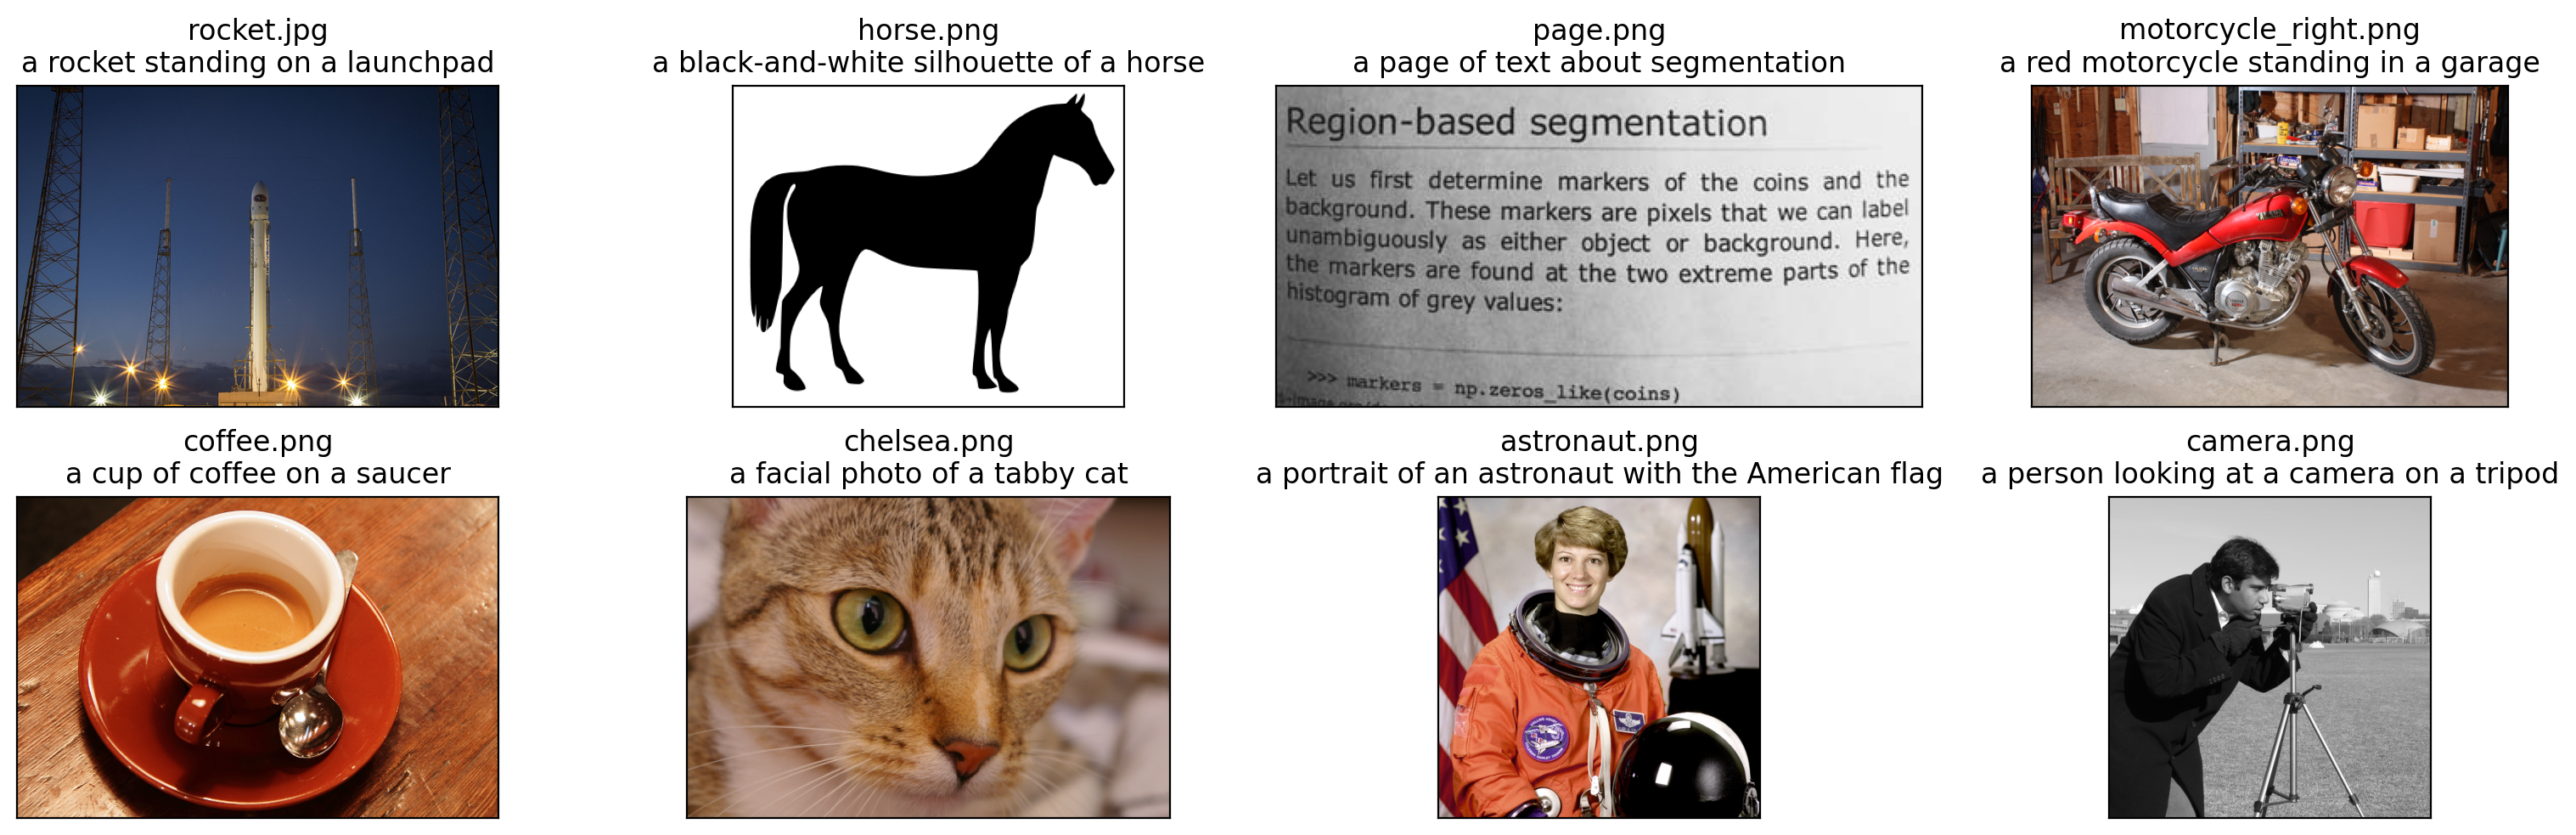

In [7]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


# Building Features for these images and their corresponding descriptions using tokenizer and encoder

In [8]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

In [9]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [21]:
print(f'Shape of image features: {image_features.shape}')
print(f'Shape of text features: {text_features.shape}')

Shape of image features: torch.Size([8, 512])
Shape of text features: torch.Size([8, 512])


# Normalize embeddings to get them into the same magnitude in shared latent space

In [10]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate the similarity between Image embeddings and text embeddings

Text(0.5, 1.0, 'Cosine similarity between text and image features')

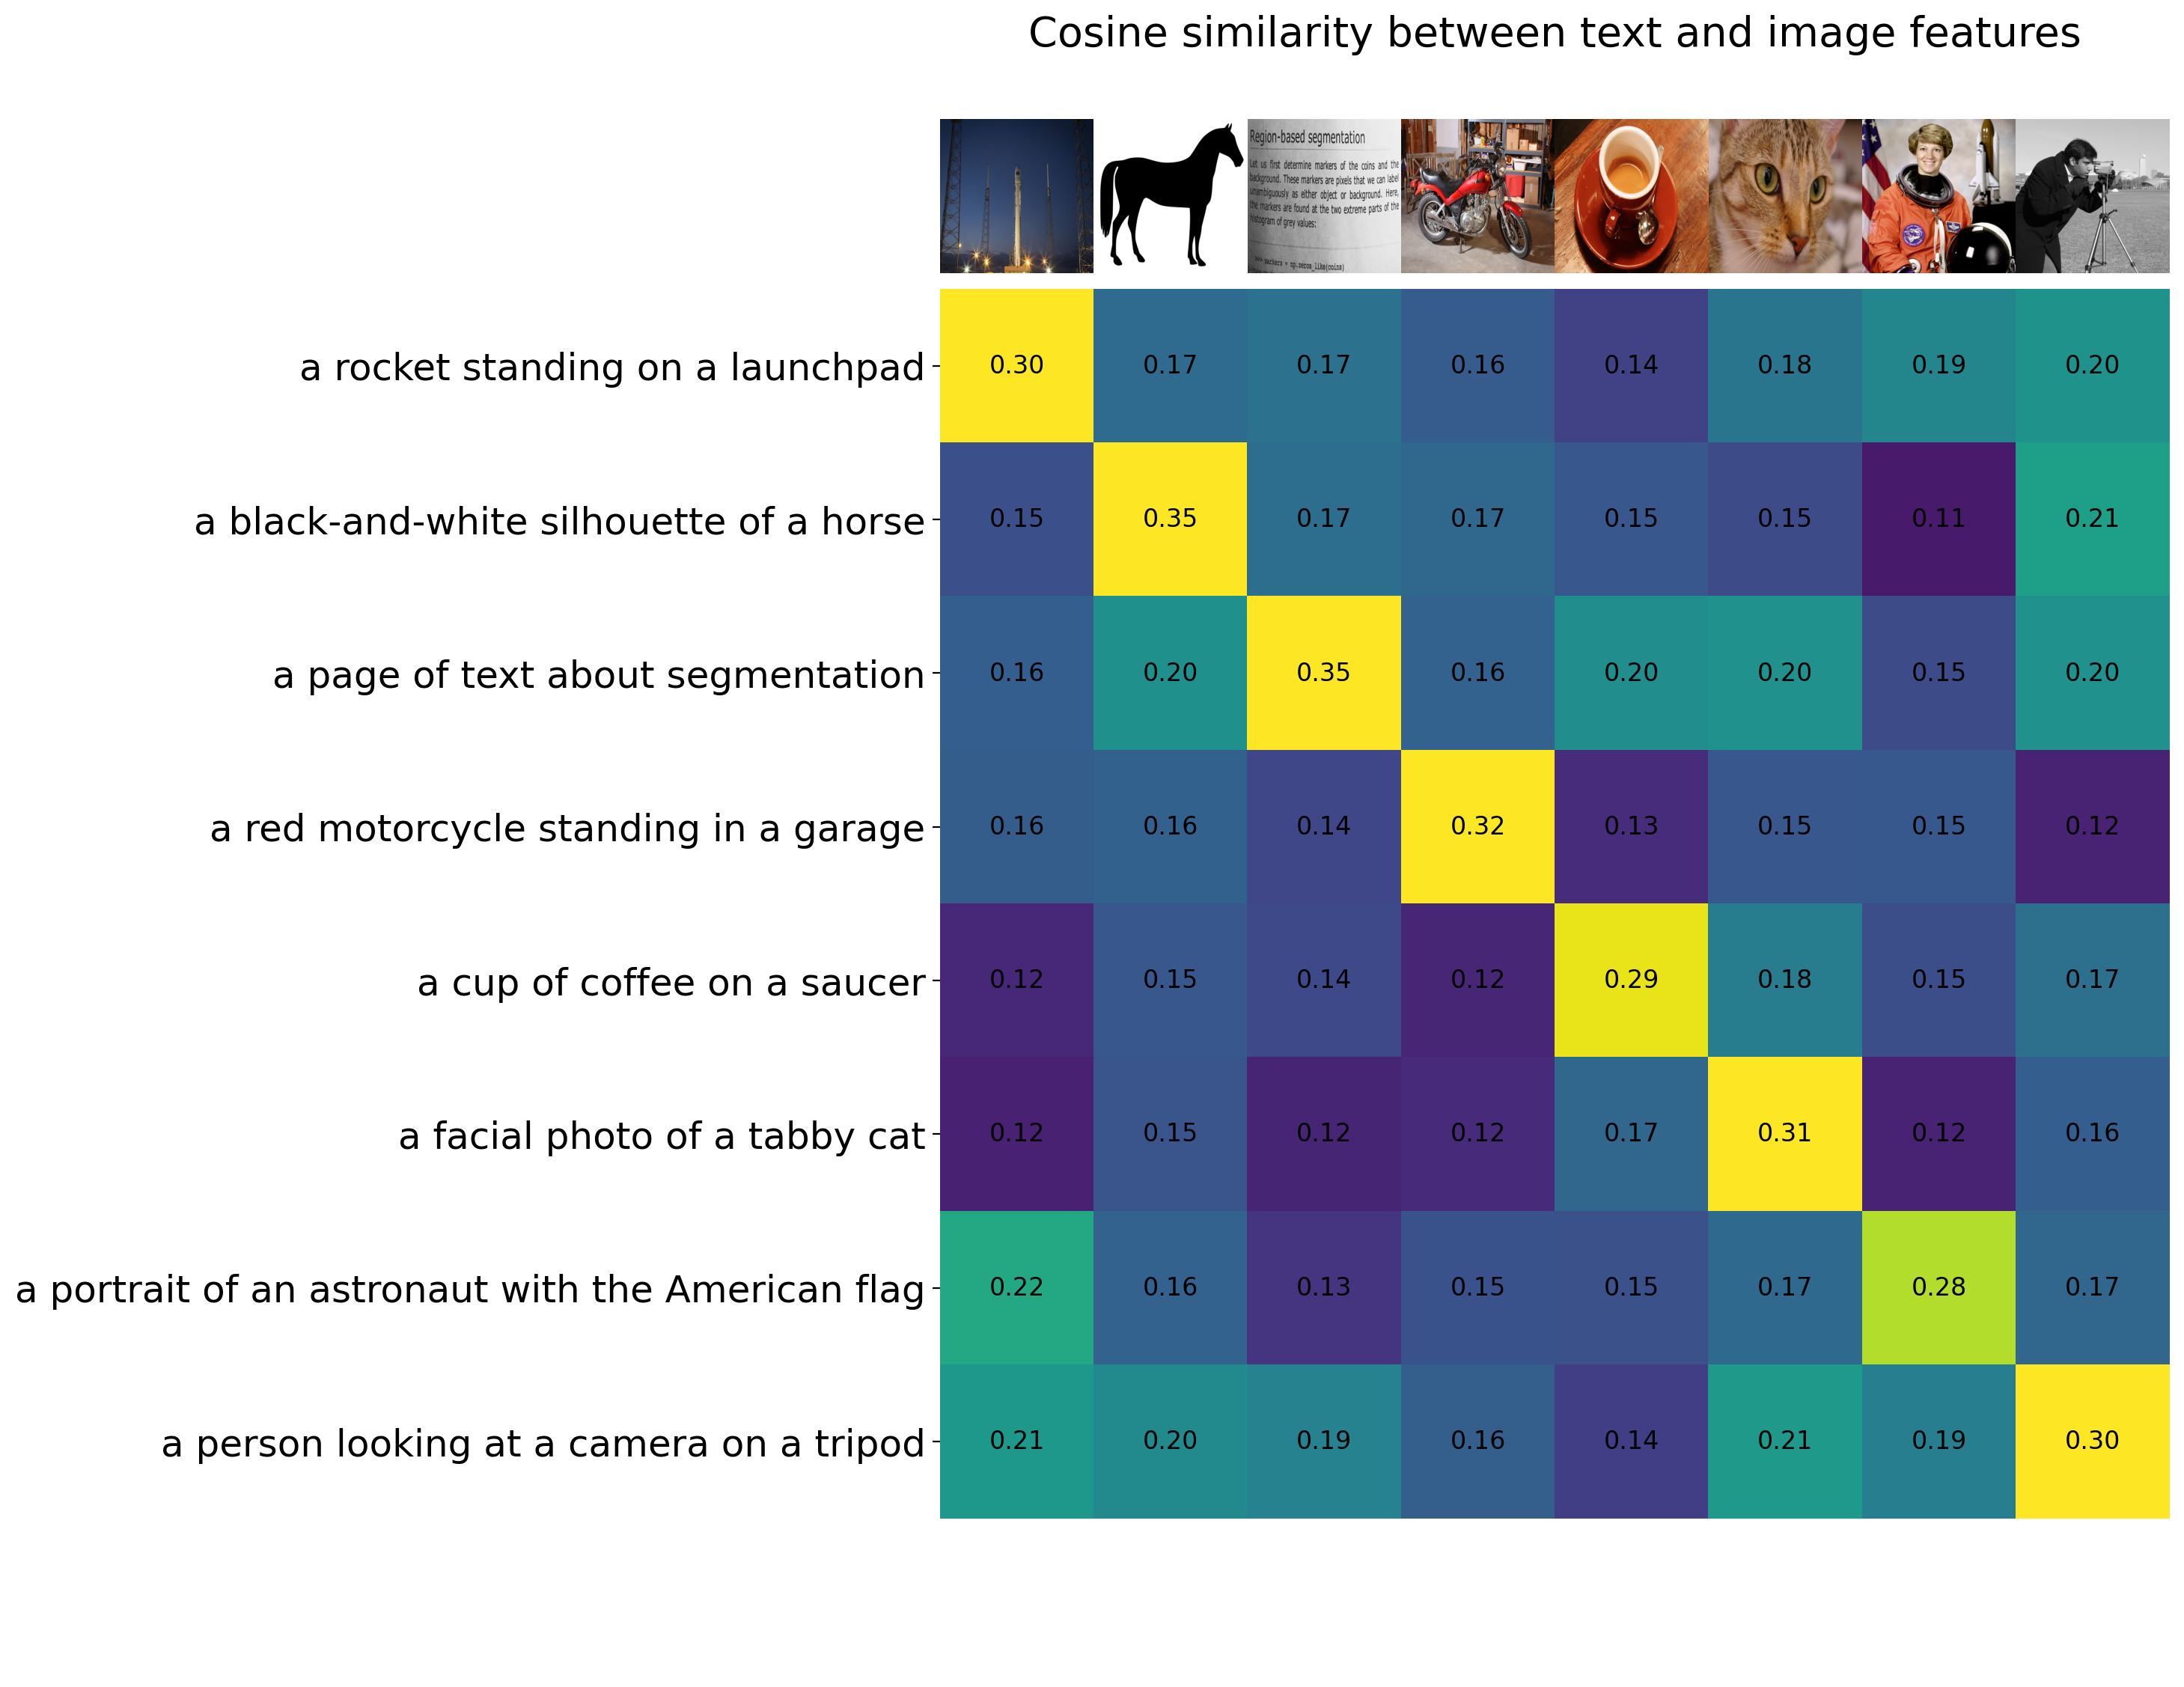

In [11]:
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

# Plot the cosine similarity
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Testing- Zero Shot CLassification

In [12]:
def clip_probabilities(model, text, image_vector, top_k_probs=2):
    text_tokens= clip.tokenize(text)
    #image_vector= image.unsequeeze(0)
    
    with torch.no_grad():
        text_embeddings= model.encode_text(text_tokens).float()
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

        image_embeddings= model.encode_image(image_vector).float()
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

    similarity = (100 * image_embeddings @ text_embeddings.T).softmax(dim=-1)
    return_prob, return_labels= similarity.topk(top_k_probs, dim=-1)
    return return_prob, return_labels

## On Labels extracted from CIFAR100 dataset

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
return_prob, return_labels= clip_probabilities(model, text_descriptions, image_input,5)

Files already downloaded and verified


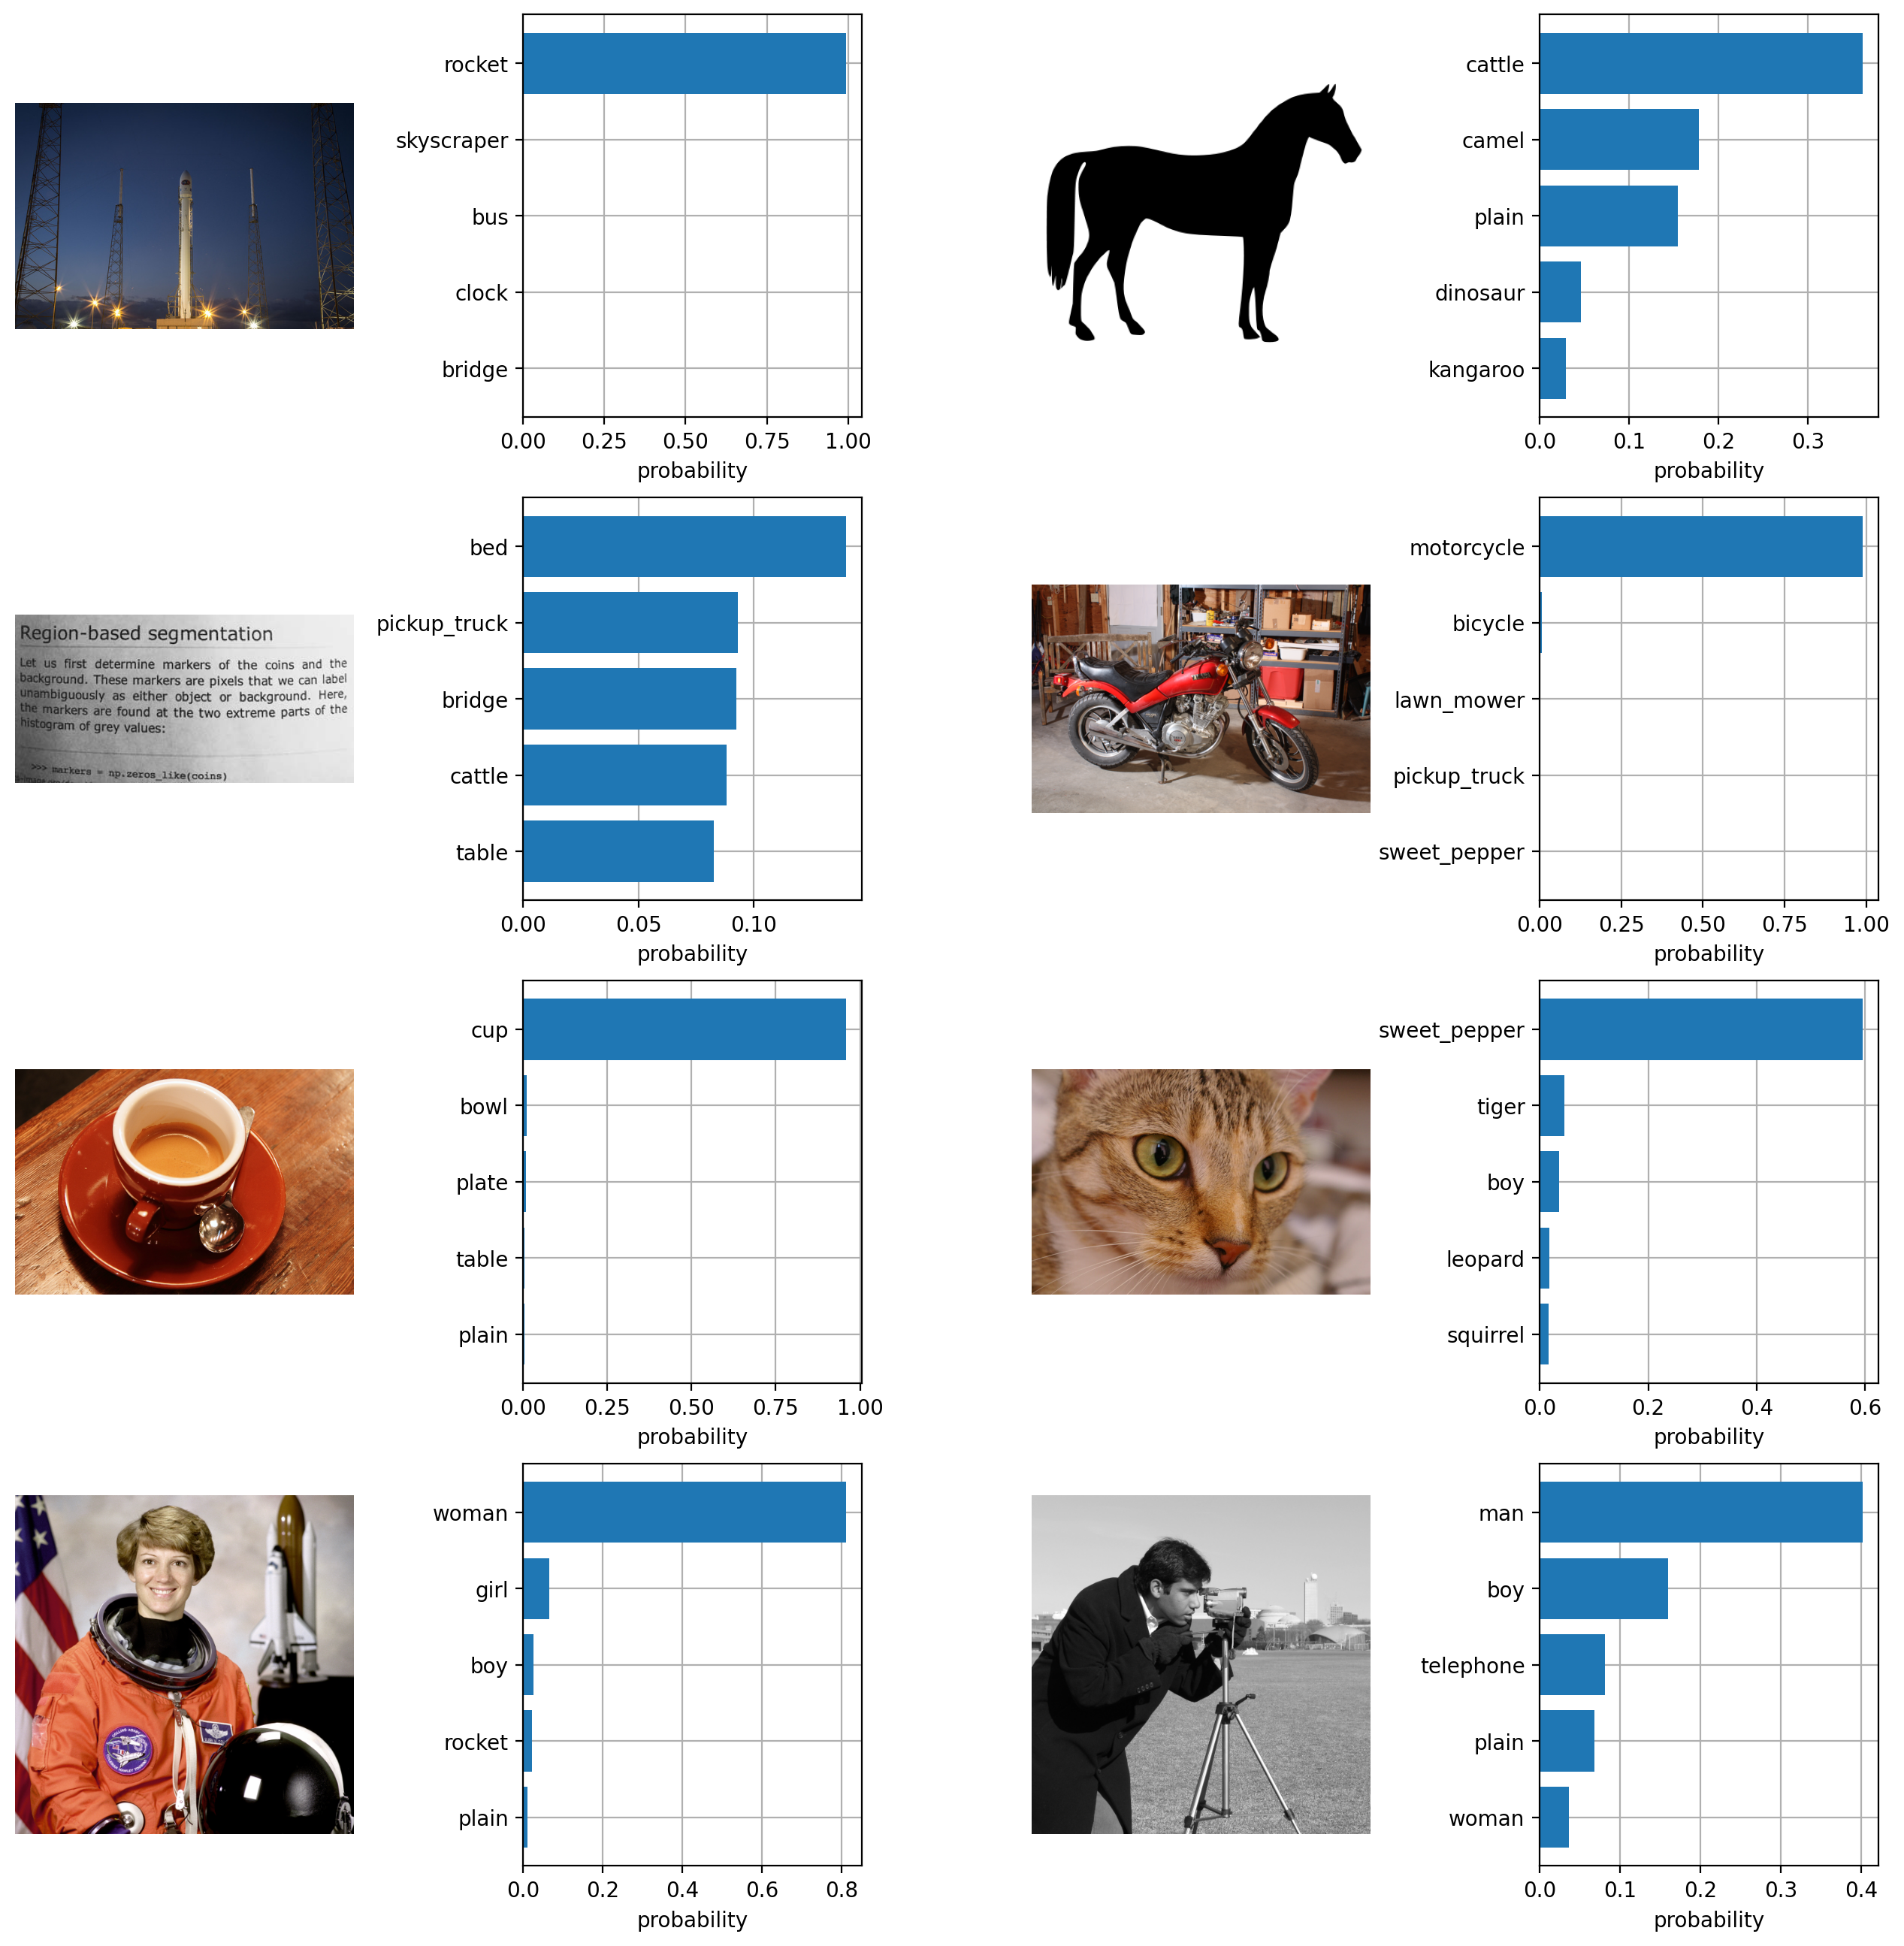

In [14]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(return_prob.shape[-1])
    plt.grid()
    plt.barh(y, return_prob[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in return_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## To demonstrate Complexity in labels

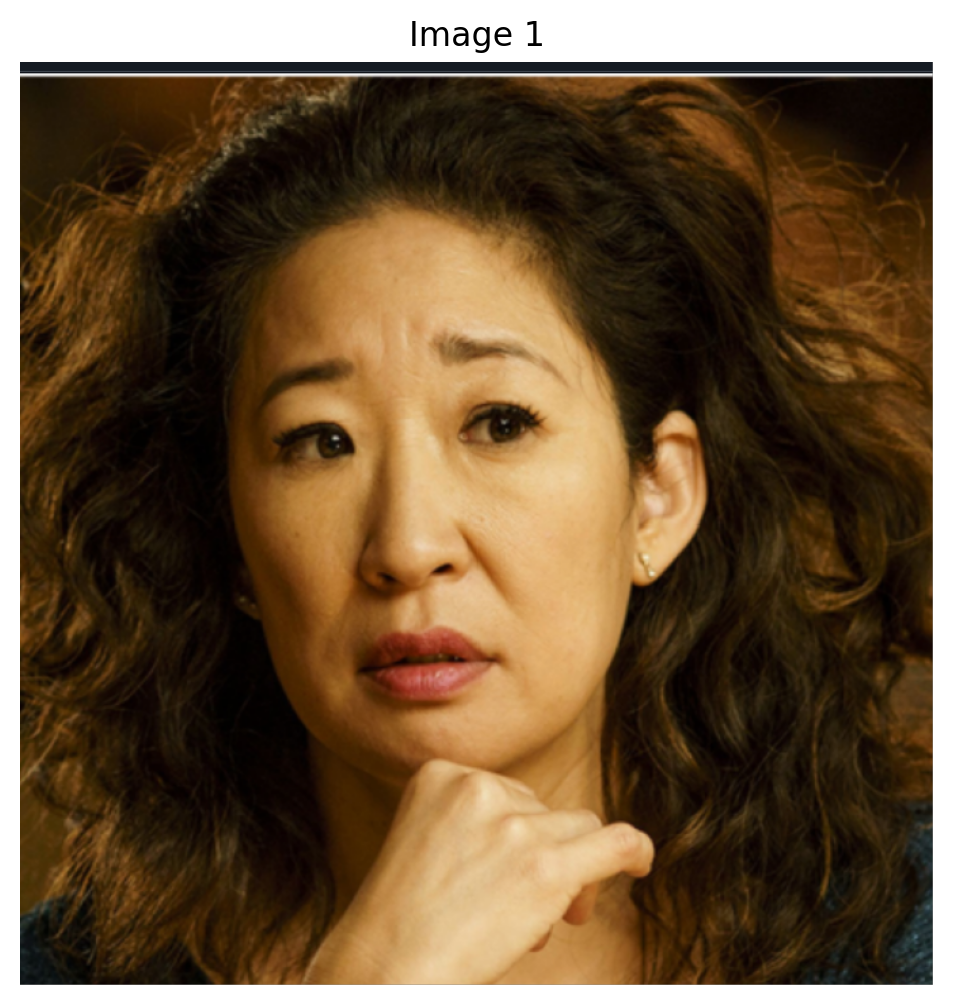

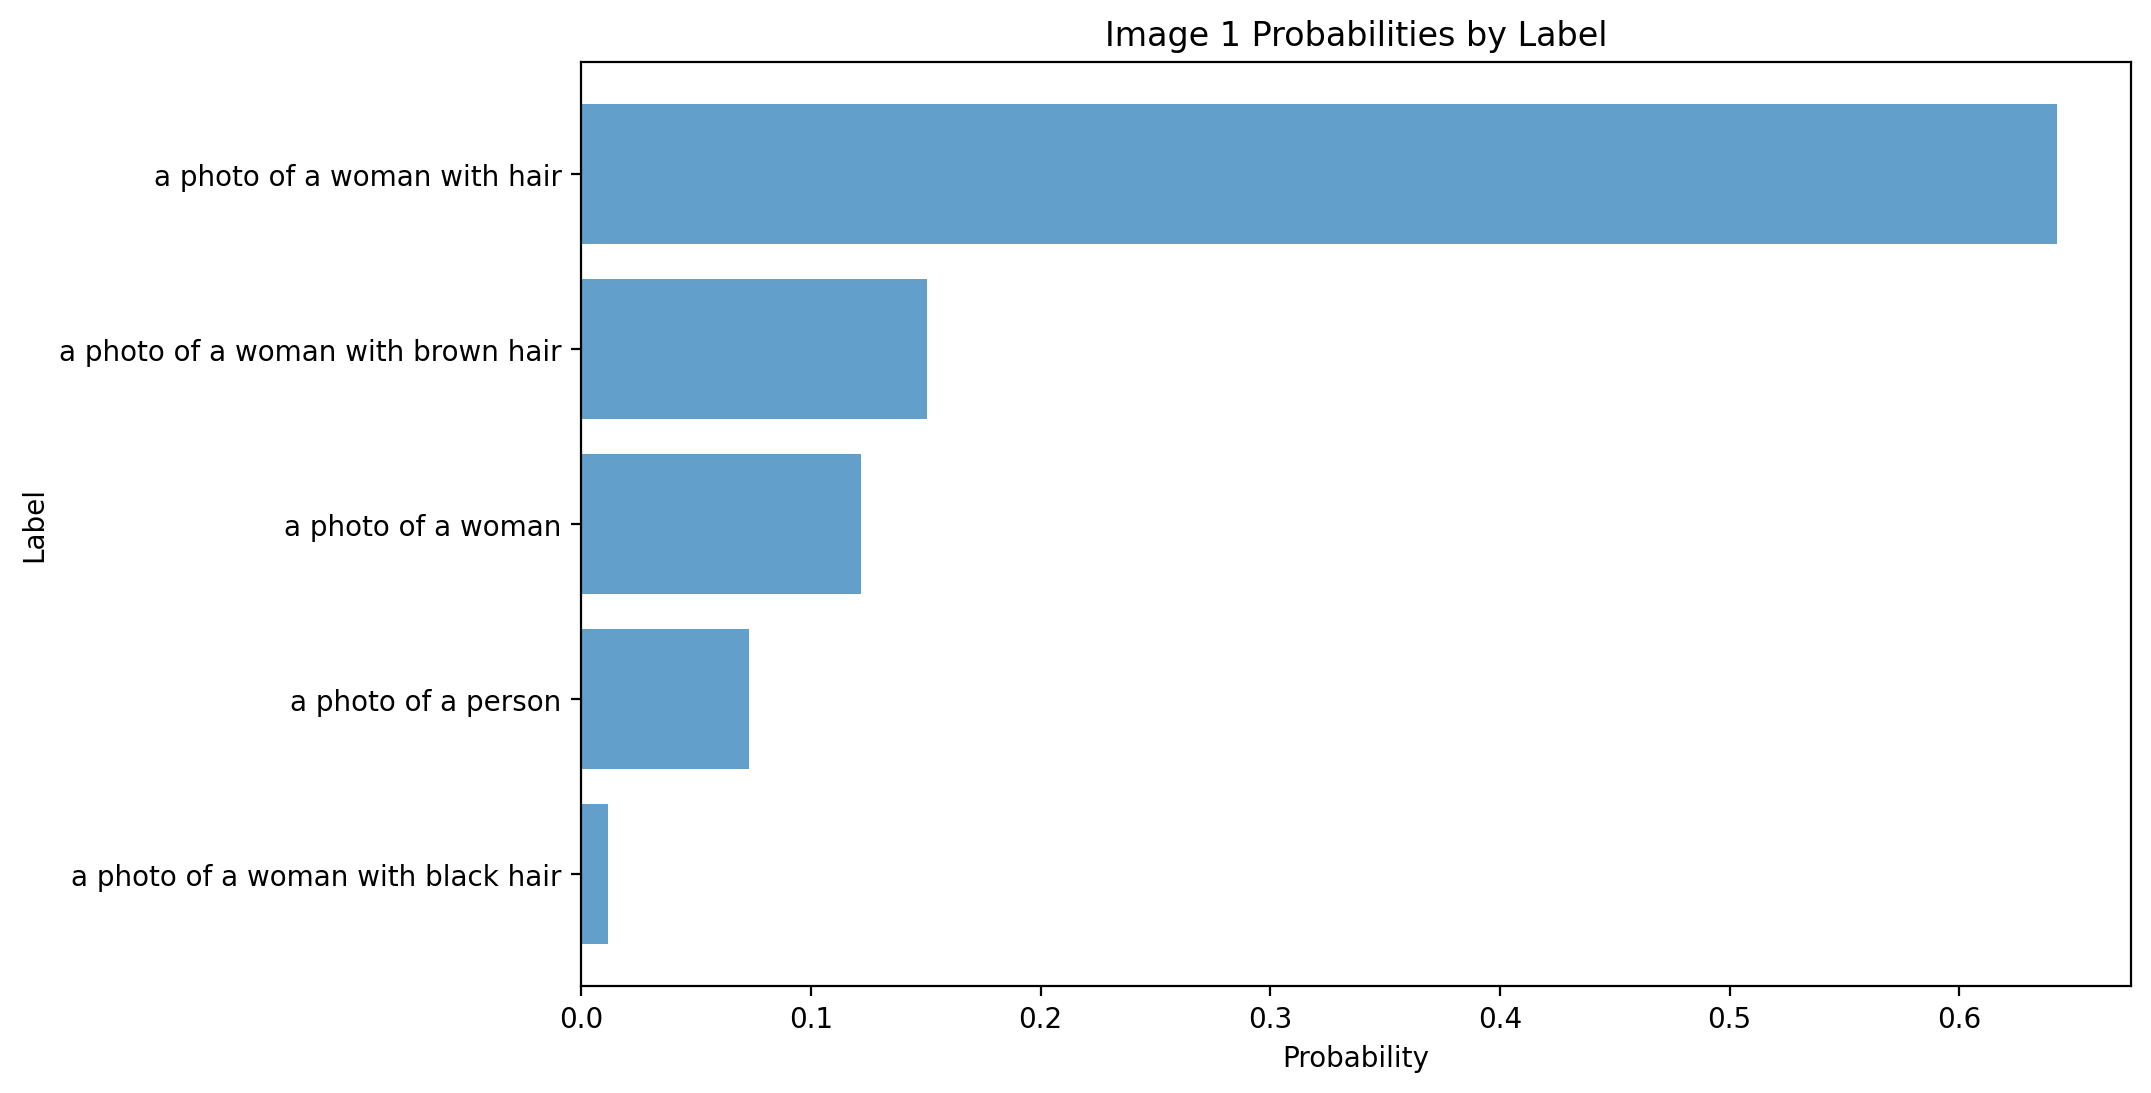

In [15]:
# Load and preprocess the image
original_image= Image.open("./Datasets/ImagesForNotebook/woman.png")
image = preprocess(original_image).unsqueeze(0)

# Define the labels
labels = ["a photo of a woman with black hair", "a photo of a woman", "a photo of a person", "a photo of a woman with hair", "a photo of a woman with brown hair"]

return_prob, return_labels= clip_probabilities(model, labels, image,5)

# Iterate over the batch of images
for i, (probs, indices) in enumerate(zip(return_prob, return_labels)):
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    
    # Convert probabilities to numpy
    probs = probs.numpy()
    
    # Get the corresponding labels for the top-k indices
    selected_labels = [labels[idx] for idx in indices]
    
    # Plot the probabilities
    plt.figure(figsize=(10, 6))
    plt.barh(selected_labels, probs, align='center', alpha=0.7)
    plt.xlabel("Probability")
    plt.ylabel("Label")
    plt.title(f"Image {i+1} Probabilities by Label")
    plt.gca().invert_yaxis()  # Invert to have the highest probability on top
    plt.show()

## To demonstrate Counting of objects

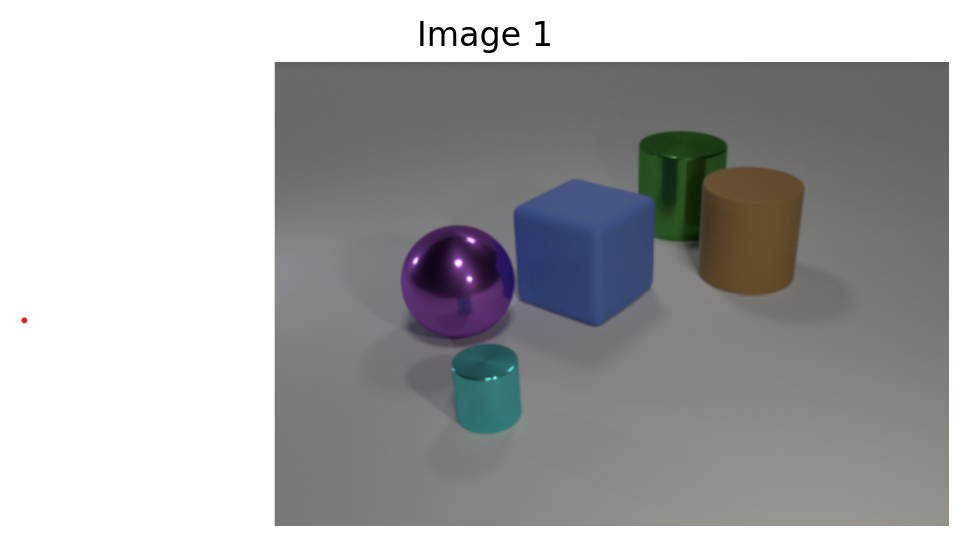

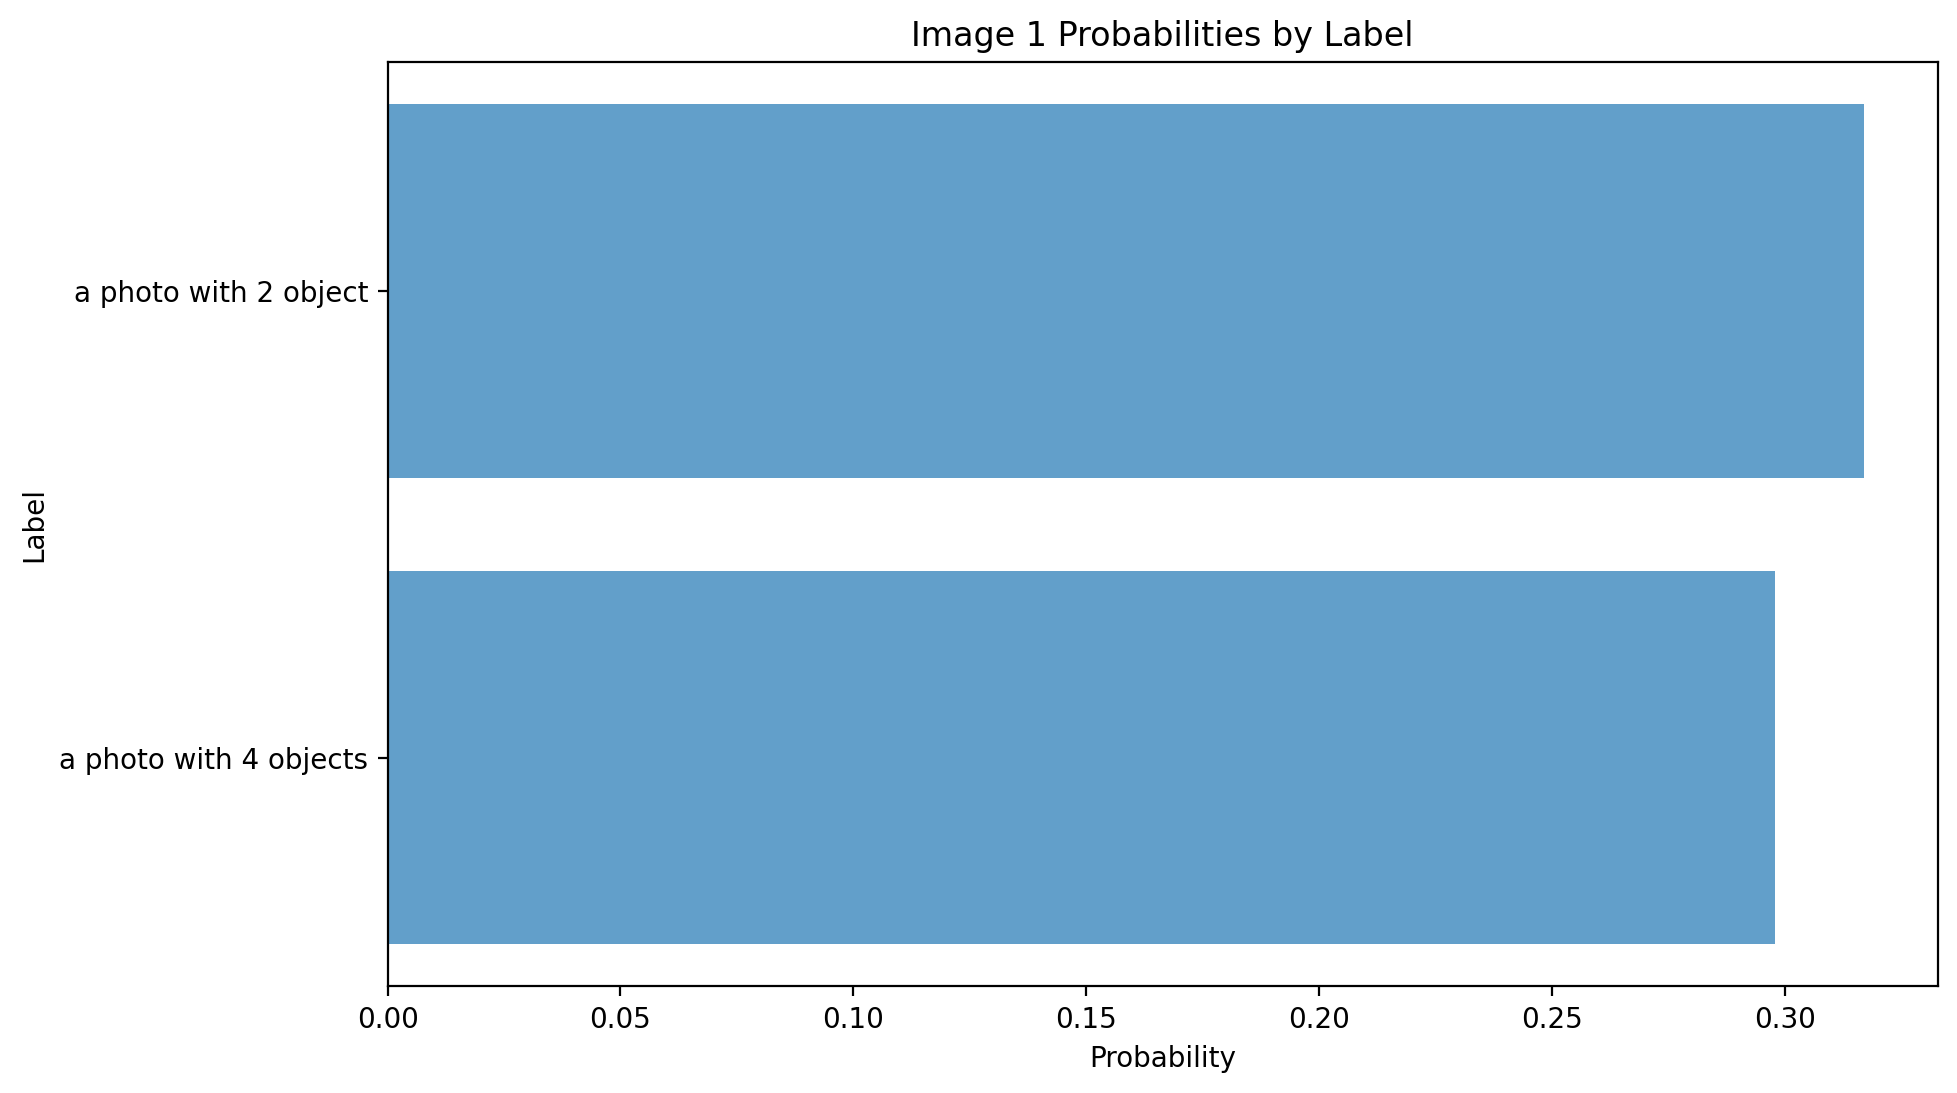

In [16]:
# Load and preprocess the image
original_image= Image.open("./Datasets/ImagesForNotebook/objects.png")
image = preprocess(original_image).unsqueeze(0)

# Define the labels
labels = ["a photo with 2 object", "a photo with 3 objects", "a photo with 4 objects", "a photo with 5 objects"]

return_prob, return_labels= clip_probabilities(model, labels, image,2)

# Iterate over the batch of images
for i, (probs, indices) in enumerate(zip(return_prob, return_labels)):
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    
    # Convert probabilities to numpy
    probs = probs.numpy()
    
    # Get the corresponding labels for the top-k indices
    selected_labels = [labels[idx] for idx in indices]
    
    # Plot the probabilities
    plt.figure(figsize=(10, 6))
    plt.barh(selected_labels, probs, align='center', alpha=0.7)
    plt.xlabel("Probability")
    plt.ylabel("Label")
    plt.title(f"Image {i+1} Probabilities by Label")
    plt.gca().invert_yaxis()  # Invert to have the highest probability on top
    plt.show()

1. **Zero-Shot Classification**: Classify images into categories without additional training by leveraging natural language prompts.
    
2. **Multimodal Search/ Scientific Research**: Perform image-to-text or text-to-image retrieval in a shared embedding space.
    
3. **Few-Shot Learning**: Adapt to new tasks with minimal labeled examples via fine-tuning or prompt engineering.
    
4. **Open-Ended Visual Reasoning/Performing Visual Task**: Handle complex queries involving combinations of visual and linguistic concepts.
    
5. **Image Captioning**: Generate descriptions for images by combining CLIP with language models (by using another agent to analyze the embeddings).
    
6. **Content Moderation**: Identify inappropriate or harmful visual content based on text descriptions.
    
7. **Visual Grounding**: Highlight specific regions in an image based on textual queries.
    
8. **Image Style Transfer**: Guide style transformations of images using text prompts.
    
10. **Visual Question Answering (VQA)**: Answer questions about an image by leveraging multimodal understanding.
    
11. **Accessibility Tools**: Describe images or objects in real-time for visually impaired users.